In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/water-hammer

/content/drive/.shortcut-targets-by-id/1nDX9YU-MkzKosEDp7ip2asiWdDi2DBld/water-hammer


In [3]:
ls all_vid

ls: cannot access 'all_vid': No such file or directory


# Thay đổi folder tên bệnh nhân

## Folder output: https://drive.google.com/drive/folders/18HlKBqe04RMC8TrB1HPvCGGh2kb_jodH?usp=sharing

In [4]:
# patient_folder = "all_videos/BAU_DO_THIse000_yes_29_54_56/"
# patient_folder = "all_videos/BE_NGUYEN_THIse000_yes_26_52_54/"
# patient_folder = "all_videos/CHINH_NGUYEN_VANse000_yes_34_60_60/"
# patient_folder = "all_videos/CHU_DUONG_VANse000_yes_34_62_62/"
# patient_folder = "all_videos/HOA_HO_DOANse000_yes_31_43_46/"
# patient_folder = "all_videos/DAI_LE_XUANse000_yes_22_37_41/"
# patient_folder = "all_videos/HOI_NGUYEN_VANse001_yes_30_61_69"
# patient_folder = "all_videos/DANG_NGUYEN_THIse002_yes_13_21_37/"
patient_folder = "all_videos/KHUONG_VO_VANse000_yes_23_55_57/"
# patient_folder = "all_videos/DAU_LAI_THIse000_yes_27_39_55/"

In [5]:
import os
os.listdir(patient_folder)

['KHUONG_VO_VANse000_54.png',
 'KHUONG_VO_VANse000_74.png',
 'KHUONG_VO_VANse000_32.png',
 'KHUONG_VO_VANse000_64.png',
 'KHUONG_VO_VANse000_66.png',
 'KHUONG_VO_VANse000_90.png',
 'KHUONG_VO_VANse000_86.png',
 'KHUONG_VO_VANse000_12.png',
 'KHUONG_VO_VANse000_44.png',
 'KHUONG_VO_VANse000_46.png',
 'KHUONG_VO_VANse000_8.png',
 'KHUONG_VO_VANse000_0.png',
 'KHUONG_VO_VANse000_28.png',
 'KHUONG_VO_VANse000_56.png',
 'KHUONG_VO_VANse000_18.png',
 'KHUONG_VO_VANse000_36.png',
 'KHUONG_VO_VANse000_10.png',
 'KHUONG_VO_VANse000_4.png',
 'KHUONG_VO_VANse000_42.png',
 'KHUONG_VO_VANse000_6.png',
 'KHUONG_VO_VANse000_48.png',
 'KHUONG_VO_VANse000_2.png',
 'KHUONG_VO_VANse000_50.png',
 'KHUONG_VO_VANse000_20.png',
 'KHUONG_VO_VANse000_26.png',
 'KHUONG_VO_VANse000_30.png',
 'KHUONG_VO_VANse000_78.png',
 'KHUONG_VO_VANse000_68.png',
 'KHUONG_VO_VANse000_80.png',
 'KHUONG_VO_VANse000_60.png',
 'KHUONG_VO_VANse000_24.png',
 'KHUONG_VO_VANse000_16.png',
 'KHUONG_VO_VANse000_70.png',
 'KHUONG_VO_VAN

# Pipeline xử lý

In [6]:
from vessel_segmentation_pytorch import DenseNet121, calculate_metrics
import torch
import matplotlib.pyplot as plt
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [7]:
device = "cuda"
model = DenseNet121().to(device)
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [8]:
def predict_image(model, cv_img, device, img_size=(512, 512)):
    """
    Same as above but skips PIL/transforms altogether.
    cv_img must be a numpy array H×W or H×W×3 (BGR).
    """
    # 1) gray + resize
    gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY) if cv_img.ndim==3 else cv_img
    H1, W1 = img_size
    resized = cv2.resize(gray, (W1, H1), interpolation=cv2.INTER_AREA)

    # 2) to tensor [0,1]
    x = torch.from_numpy(resized).unsqueeze(0).unsqueeze(0).float() / 255.0
    x = x.to(device)

    # 3) predict & binarize
    model.eval()
    with torch.no_grad():
        out = model(x)                     # (1,1,H1,W1)
        mask = (out > 0.5).float().cpu().squeeze()  # (H1,W1), 0.0 or 1.0

    # 4) to 0/255 uint8
    mask_255 = (mask.numpy() * 255).astype(np.uint8)

    # 5) match: mask * resized image
    matched = cv2.bitwise_and(resized, resized, mask=mask_255)

    return mask_255, matched

In [9]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from skimage.morphology import skeletonize
import datetime
import math
from typing import List, Tuple
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Global parameters and functions

WINDOW_SIZE = 20
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

MAX_VECTORS = 90
MAX_FRAMES = 75
SPLIT_FRAMES = 15
OVERLAY = 5
ITEMS = int((MAX_FRAMES - OVERLAY) / (SPLIT_FRAMES - OVERLAY)) + 1

In [10]:
def find_largest_contour(contours):
    max_contour = None
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    return max_contour

def remove_catheter(image):
    original_image = image.copy()
    vessel_img, _ = predict_image(model, original_image, device)

    # remove catheter
    subtract_image = vessel_img
    _, binary = cv2.threshold(subtract_image, 50, 255, cv2.THRESH_BINARY)
    binary = binary.astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    if len(contours)>1:
        mask = np.zeros_like(binary)
        try:
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
            vessel_img = cv2.bitwise_and(subtract_image, subtract_image, mask=mask)
        except:
            print("fail here")

    resized_img = cv2.resize(original_image, (512, 512))
    pred_img = vessel_img/255.
    match_img = resized_img*pred_img
    return pred_img, match_img

# Sort windows
def find_catheter_last_point(catheter_img):
    width, height = np.where(catheter_img!=0)
    if len(width)==0 or len(height)==0:
        return 0, 0
    max_width = np.max(width)
    max_height = np.max(height)
    return max_height, max_width

def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def min_distance(x,y, vector, limit):
    if limit > 0:
        d = [distance(x, y, vector[i][0],vector[i][1]) for i in range(limit)]
        d.sort()
        return d[0]
    return 1000

def vectorize_one_image_using_center_line(img, previous_path=None):
    vector = np.zeros((MAX_VECTORS, 3), dtype=np.float32)
    STEP = 5

    pred_img, match_img = remove_catheter(img)

    centerline = skeletonize(pred_img.astype(int))
    centerline = centerline.astype(np.float32)

    if np.all(pred_img == 0):
        print("Fall here")
        return vector, None, None, match_img, pred_img

    try:
        img_with_rectangles = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR)
    except:
        img_with_rectangles = match_img.copy()
    centerline_with_rect = cv2.cvtColor(centerline * 255, cv2.COLOR_GRAY2BGR)
    index = 0
    WS12 = WINDOW_SIZE // 2
    IMAGE_DIM = (IMAGE_HEIGHT, IMAGE_WIDTH)

    for y in range(0, IMAGE_DIM[0], STEP):
        for x in range(0, IMAGE_DIM[1], STEP):
            window = centerline[y:y + STEP, x:x + STEP]
            if np.count_nonzero(window) > 2:
                y_arr, x_arr = np.where(window == 1)
                x_w = int(x_arr.mean()) + x
                y_w = int(y_arr.mean()) + y

                if min_distance(x_w, y_w, vector, index) > WS12*0.1:
                    upper_left = (max(0, x_w - WS12), max(0, y_w - WS12))
                    lower_right = (min(IMAGE_WIDTH, x_w + WS12), min(IMAGE_HEIGHT, y_w + WS12))

                    if (lower_right[0] - upper_left[0]) <= 0 or (lower_right[1] - upper_left[1]) <= 0:
                        continue

                    window = match_img[upper_left[1]:lower_right[1], upper_left[0]:lower_right[0]]
                    centerline[upper_left[1]:lower_right[1], upper_left[0]:lower_right[0]] = 0

                    cv2.rectangle(img_with_rectangles, upper_left, lower_right, (0, 255, 0), 1)
                    cv2.rectangle(centerline_with_rect, upper_left, lower_right, (0, 255, 0), 1)

                    pixel_count = np.average(window)
                    vector[index] = [x_w, y_w, pixel_count]
                    index += 1
                    if index >= MAX_VECTORS:
                        vector = sort_by_distance(vector, pred_img)
                        return vector, img_with_rectangles, centerline_with_rect, match_img, pred_img

    vector = sort_by_distance(vector, pred_img, previous_path)
    return vector, img_with_rectangles, centerline_with_rect, match_img, pred_img

## Sort vectors
def most_left_upper_point(points: List[Tuple[float, float]]) -> Tuple[float, float, float]:
    most_left_upper = points[0]

    for point in points[1:]:
        if point[0]==0 and point[1]==0:
            continue
        if point[0] < most_left_upper[0] or (point[0] == most_left_upper[0] and point[1] < most_left_upper[1]):
            most_left_upper = point

    return most_left_upper

def calculate_angle(point1, point2, point3):
    vector1 = (point1[0] - point2[0], point1[1] - point2[1])
    vector2 = (point3[0] - point2[0], point3[1] - point2[1])
    dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]

    magnitude1 = math.sqrt(vector1[0]**2 + vector1[1]**2)
    magnitude2 = math.sqrt(vector2[0]**2 + vector2[1]**2)

    cosine_theta = dot_product / (magnitude1 * magnitude2)
    cosine_theta = max(-1, min(1, cosine_theta))
    theta_rad = math.acos(cosine_theta)

    theta_deg = math.degrees(theta_rad)

    return theta_deg

def vector_distance(point1: Tuple[float, float], point2: Tuple[float, float]) -> float:
    x1, y1 = point1
    x2, y2 = point2
    center_distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    return max(0, center_distance - WINDOW_SIZE)

def calculate_ratio(previous_point: Tuple[float, float], current_point: Tuple[float, float], next_point: Tuple[float, float], image) -> float:
    if previous_point[0]!=0 and previous_point[1]!=0:
        angle = calculate_angle(previous_point, current_point, next_point)
    else:
        angle = 0

    line_overlapping = calculate_line_overlapping(image, next_point[:2], current_point[:2])
    return 0.7*angle + 0.3*line_overlapping

def get_line_points(image, point1, point2):
    blank_image = np.zeros_like(image)
    point1 = point1.astype(int)
    point2 = point2.astype(int)
    cv2.line(blank_image, (point1[0], point1[1]), (point2[0], point2[1]), 255, 1)
    line_points = np.column_stack(np.where(blank_image == 255))
    return line_points

def calculate_line_overlapping(binary_image, point1, point2):
    line_points = get_line_points(binary_image, point1, point2)
    overlap_count = 0
    total_line_points = len(line_points)
    for point in line_points:
        x, y = point
        if binary_image[x, y] != 0:
            overlap_count += 1
    overlap_percentage = (overlap_count / total_line_points) * 100
    return overlap_percentage

def find_overlap_points(x1, y1, x2, y2):
    x1_tl = x1 - WINDOW_SIZE // 2
    y1_tl = y1 - WINDOW_SIZE // 2
    x1_br = x1 + WINDOW_SIZE // 2
    y1_br = y1 + WINDOW_SIZE // 2

    x2_tl = x2 - WINDOW_SIZE // 2
    y2_tl = y2 - WINDOW_SIZE // 2
    x2_br = x2 + WINDOW_SIZE // 2
    y2_br = y2 + WINDOW_SIZE // 2

    # Calculate the overlapping region
    xmin = max(x1_tl, x2_tl)
    ymin = max(y1_tl, y2_tl)
    xmax = min(x1_br, x2_br)
    ymax = min(y1_br, y2_br)

    # Check if there's an overlap
    if xmin < xmax and ymin < ymax:
        return np.array([xmin, ymin, xmax, ymax])
    else:
        return []

def dfs(current_point: Tuple[float, float, float], remaining_points: List[Tuple[float, float, float]], path: List[Tuple[float, float, float]], queue: List[Tuple[float, float, float]], reset_branch: Tuple[float, float], previous_point: Tuple[float, float], image, previous_path=None) -> List[Tuple[float, float, float]]:
    if not (reset_branch[0]!=0 and reset_branch[1]!=0) or len(path)==0:
        path.append(current_point)
    if not remaining_points:
        return path

    remaining_points.sort(key=lambda point: vector_distance((point[0], point[1]), (current_point[0], current_point[1])))
    branches = []
    temp_branches = []
    for chosen_point in remaining_points[:5]:
        distance = vector_distance((chosen_point[0], chosen_point[1]), (current_point[0], current_point[1]))
        if distance < 20.:
            temp_branches.append(chosen_point)
        else:
            break

    if len(temp_branches)>1:
        for chosen_point in temp_branches:
            overlap_points = find_overlap_points(chosen_point[0], chosen_point[1], current_point[0], current_point[1])
            if len(overlap_points)>0:
                xmin, ymin, xmax, ymax = overlap_points.astype(int)
                overlapping_part = image[ymin:ymax, xmin:xmax]
                lines = len(np.where(overlapping_part>0)[0])
                if overlapping_part.shape[0]*overlapping_part.shape[1]==0:
                    if calculate_line_overlapping(image, chosen_point[:2], current_point[:2])>90:
                        branches.append(chosen_point)
                elif (lines/(overlapping_part.shape[0]*overlapping_part.shape[1]))>0.1:
                    branches.append(chosen_point)
                    continue
        else:
            if calculate_line_overlapping(image, chosen_point[:2], current_point[:2])>85.:
                branches.append(chosen_point)
    else:
        branches = temp_branches
    if len(branches)>1:
        for time_appeared in branches[0:]:
            queue.append(current_point)
        branches.sort(key=lambda point: calculate_ratio(previous_point, current_point, point, image), reverse=True)

    if len(branches)>0:
        previous_point = current_point
        if len(branches)>1 and type(previous_path)!=type(None):
            next_point = find_next_point(branches, len(path)-1, current_point[:2], previous_path)
        else:
            next_point = branches[0]
        reset_branch = [0, 0]
        remove_index = next(i for i, point in enumerate(remaining_points) if np.array_equal(point, next_point))
        remaining_points.pop(remove_index)
    else:
        if path[-1][0]!=-1:
            path.append([-1,-1,-1])
        if len(queue)>0:
            next_point = queue.pop(0)
            reset_branch = next_point[:2]
            previous_point = [0,0]
        else:
            next_point = remaining_points.pop(0)
            reset_branch = [0, 0]
            previous_point = [0,0]

    return dfs(next_point, remaining_points, path, queue, reset_branch, previous_point, image, previous_path)

def find_next_point(branches, current_index, current_point, previous_path):
    if (current_index+2)>len(previous_path):
        return branches[0]
    previous_point = previous_path[current_index][:2]
    next_point = previous_path[current_index+1][:2]

    if next_point[0]==-1:
        return branches[0]

    movement_vector = np.array(next_point) - np.array(previous_point)
    predict_point = np.array(current_point) + movement_vector

    branches.sort(key=lambda point: vector_distance(point[:2], predict_point[:2]))
    point = branches[0]
    return point

def sort_by_distance(points: List[Tuple[float, float, float]], image, previous_path=None) -> List[Tuple[float, float, float]]:
    if type(previous_path)==type(None):
        catheter_x, catheter_y = 0, 0
        if catheter_x!=0 and catheter_y!=0:
            remaining_points = [point for point in points]
            remaining_points.sort(key=lambda point: vector_distance((point[0], point[1]), (catheter_x, catheter_y)))
            initial_point = remaining_points[0]
        else:
            initial_point = most_left_upper_point(points)
    else:
        initial_point = previous_path[0]

    points = [point for point in points if not np.array_equal(point, initial_point) and not np.array_equal(point, (0,0,0))]
    sorted_points = dfs(initial_point, points, [], [], initial_point, [0,0], image, previous_path)
    return sorted_points
def get_index_files(filename):
    return int(re.findall(r"_(\d+).png", filename)[0])

In [11]:
frames = os.listdir(patient_folder)
index_list = list(map(get_index_files, frames))
sorted_frames = [filename for _, filename in sorted(zip(index_list, frames))]
index_list = sorted(index_list)

# Find max segmentation
max_pixels_sum = 0
min_index = 0
max_index= 0
for frame_index, frame in tqdm(enumerate(sorted_frames)):
    frame = os.path.join(patient_folder, frame)
    frame = cv2.imread(frame, 0)
    pred_img = remove_catheter(frame)
    pixels_sum = np.sum(pred_img)
    if pixels_sum==0 and min_index!=0:
        max_index=frame_index
    if pixels_sum>max_pixels_sum:
        max_pixels_sum=pixels_sum
        min_index = frame_index
if max_index<min_index and min_index!=0:
  max_index = len(sorted_frames)-1
print(max_index, min_index)

57it [00:49,  1.15it/s]

56 22


In [12]:
ITEMS = max_index - min_index + 1

In [13]:
images = np.zeros((ITEMS, MAX_VECTORS, WINDOW_SIZE, WINDOW_SIZE))
vectors = np.zeros((ITEMS, MAX_VECTORS, 3))

In [14]:
current_index = 0
frames_count = 0
previous_path = None
for frame_index, frame in tqdm(enumerate(sorted_frames)):

    if frame_index<min_index:
        continue
    if frame_index>max_index:
        break

    frame = os.path.join(patient_folder, frame)
    frame = cv2.imread(frame, 0)
    if type(previous_path)==type(None):
        vector, img_with_rectangles, centerline_with_rect, match_img, pred_img = vectorize_one_image_using_center_line(frame)
        vector = np.array(vector)
        previous_path = vector
    else:
        vector, img_with_rectangles, centerline_with_rect, match_img, pred_img = vectorize_one_image_using_center_line(frame, previous_path)
        vector = np.array(vector)
    print(vector)
    image_from_vector = []
    filter_vector = []
    for v in vector:
        if len(image_from_vector)==MAX_VECTORS:
            break
        x, y, color = v
        if x==0 and y==0:
            continue
        if x==-1 and y==-1:
            if len(filter_vector)>0:
                if filter_vector[-1][0]==-1:
                    continue
            small_image = np.zeros((WINDOW_SIZE, WINDOW_SIZE))
            filter_vector.append(v)
            image_from_vector.append(small_image)
            continue

        x = int(x)
        y = int(y)
        xmin = x-WINDOW_SIZE//2
        xmax = x+WINDOW_SIZE//2
        ymin = y-WINDOW_SIZE//2
        ymax = y+WINDOW_SIZE//2

        if xmax>IMAGE_WIDTH:
            xmin = xmin-(xmax-IMAGE_WIDTH)
            xmax = IMAGE_WIDTH
        if ymax>IMAGE_HEIGHT:
            ymin = ymin-(ymax-IMAGE_HEIGHT)
            ymax = IMAGE_HEIGHT
        if xmin<0:
            xmax = xmax + (0-xmin)
            xmin = 0
        if ymin<0:
            ymax = ymax + (0-ymin)
            ymin = 0

        small_image = match_img[ymin:ymax, xmin:xmax]
        small_pred_img = pred_img[y-1:y+1, x-1:x+1]
        if (np.sum(small_image)/(WINDOW_SIZE**2))>0.3 and len(np.where(small_pred_img==1)[0])>1:
            filter_vector.append(v)
            image_from_vector.append(small_image)
    print(len(image_from_vector))
    if len(image_from_vector)<1:
        continue
    images[frames_count][:len(image_from_vector)] = np.array(image_from_vector)
    vectors[frames_count][:len(image_from_vector)] = np.array(filter_vector)
    frames_count+=1

23it [00:00, 89.87it/s]

[[100.         277.          42.29999924]
 [106.         263.          57.71500015]
 [125.         243.          55.09000015]
 [128.         232.          55.08750153]
 [133.         218.          60.23249817]
 [135.         208.          55.97000122]
 [141.         197.          62.52750015]
 [151.         186.          61.04750061]
 [167.         179.          53.75999832]
 [200.         172.          49.95750046]
 [223.         178.          29.47750092]
 [237.         179.          26.57749939]
 [255.         168.          27.16250038]
 [252.         157.          39.06750107]
 [242.         151.          30.03249931]
 [245.         168.          28.02499962]
 [ -1.          -1.          -1.        ]
 [113.         282.          60.08750153]
 [127.         276.          46.43999863]
 [137.         287.          35.93500137]
 [ -1.          -1.          -1.        ]
 [111.         293.          65.15000153]
 [115.         332.          54.72499847]
 [120.         343.          50.41

32it [00:02, 12.17it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [133.         288.         105.44999695]
 [135.         277.         112.80750275]
 [139.         263.          90.64749908]
 [146.         248.          83.70999908]
 [152.         237.          76.06500244]
 [159.         222.          66.69249725]
 [162.         211.          63.40250015]
 [168.         198.          31.18250084]
 [187.         203.          43.48500061]
 [192.         189.          40.44499969]
 [203.         186.          30.66500092]
 [217.         183.          14.76749992]
 [228.         182.           6.58249998]
 [ -1.          -1.          -1.        ]
 [147.         288.          70.94750214]
 [162.         283.          41.50500107]
 [173.         285.          39.63000107]
 [183.         296.          35.95750046]
 [186.         307.          21.20499992]
 [ -1.          -1.          -1.        ]
 [123.         313.          46.06750107]
 [122.         327.          39.43

36it [00:03,  8.96it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [112.         265.          30.30249977]
 [123.         269.          43.08499908]
 [136.         273.          37.77249908]
 [147.         287.          43.97999954]
 [152.         298.          38.27999878]
 [155.         312.          30.07250023]
 [167.         322.          21.53249931]
 [ -1.          -1.          -1.        ]
 [119.         282.          52.12749863]
 [118.         293.          71.97250366]
 [120.         307.          71.97250366]
 [125.         322.          55.98749924]
 [132.         333.          46.01750183]
 [142.         343.          49.61000061]
 [168.         357.          56.00999832]
 [207.         364.          55.04000092]
 [216.         377.          37.52249908]
 [227.         387.          34.10749817]
 [238.         391.          26.27000046]
 [252.         396.          19.35750008]
 [ -1.          -1.          -1.        ]
 [157.         351.          53.70

39it [00:03,  7.37it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [126.         312.          16.99250031]
 [123.         323.          39.68999863]
 [129.         336.          64.05000305]
 [136.         347.          65.94750214]
 [147.         357.          57.75500107]
 [158.         361.          50.66249847]
 [172.         363.          39.88249969]
 [197.         363.          38.35499954]
 [232.         353.          52.65499878]
 [243.         351.          53.85749817]
 [257.         349.          50.76499939]
 [268.         349.          53.78250122]
 [280.         346.          60.68999863]
 [288.         356.          43.12749863]
 [308.         382.          26.92250061]
 [322.         401.          28.12750053]
 [336.         412.          20.95000076]
 [346.         423.          19.        ]
 [358.         432.          16.01000023]
 [ -1.          -1.          -1.        ]
 [183.         364.          34.38750076]
 [ -1.          -1.          -1.  

41it [00:04,  6.67it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [137.         291.          31.37750053]
 [152.         282.          35.41749954]
 [163.         281.          35.68500137]
 [176.         287.          39.06499863]
 [183.         298.          33.02999878]
 [184.         312.          19.28499985]
 [183.         323.          22.30249977]
 [ -1.          -1.          -1.        ]
 [131.         302.          24.58250046]
 [129.         313.          18.75499916]
 [129.         327.          18.26250076]
 [130.         342.          18.26749992]
 [133.         353.          21.83499908]
 [143.         366.          39.90499878]
 [157.         372.          43.52249908]
 [193.         374.          44.79750061]
 [182.         374.          40.81000137]
 [168.         374.          40.93999863]
 [ -1.          -1.          -1.        ]
 [217.         369.          47.82749939]
 [248.         363.          53.29499817]
 [237.         364.          52.68

43it [00:04,  6.28it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [147.         370.          22.42749977]
 [162.         376.          45.02500153]
 [173.         377.          42.98749924]
 [187.         377.          41.01499939]
 [198.         377.          41.29000092]
 [213.         374.          43.09000015]
 [248.         367.          51.04499817]
 [262.         365.          51.28749847]
 [278.         363.          61.12749863]
 [292.         368.          39.92250061]
 [303.         368.          36.98500061]
 [311.         382.          26.80249977]
 [311.         393.          27.86499977]
 [322.         399.          30.01749992]
 [333.         401.          26.21750069]
 [348.         416.          21.58499908]
 [ -1.          -1.          -1.        ]
 [237.         368.          50.86750031]
 [ -1.          -1.          -1.        ]
 [292.         353.          36.11750031]
 [323.         344.          30.73749924]
 [336.         352.          31.71

45it [00:05,  6.14it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [125.         297.           9.21500015]
 [125.         308.          17.50499916]
 [127.         322.          23.45000076]
 [130.         333.          26.77249908]
 [136.         347.          32.68000031]
 [147.         356.          36.52999878]
 [158.         360.          30.25749969]
 [196.         364.          23.79750061]
 [207.         364.          25.23250008]
 [218.         362.          26.12999916]
 [233.         359.          22.57250023]
 [247.         358.          12.75500011]
 [258.         358.          10.96749973]
 [272.         360.          17.88750076]
 [311.         367.          54.16500092]
 [320.         392.          34.13249969]
 [332.         399.          41.45750046]
 [343.         406.          34.85749817]
 [353.         417.          23.29000092]
 [377.         437.           9.27499962]
 [366.         427.          16.70000076]
 [ -1.          -1.          -1.  

47it [00:05,  6.38it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [125.         317.           6.88250017]
 [131.         332.          17.0625    ]
 [137.         343.          22.06999969]
 [148.         353.          29.61750031]
 [163.         360.          27.10499954]
 [177.         361.          20.45000076]
 [202.         363.          22.87750053]
 [233.         358.          29.87249947]
 [247.         356.          34.25500107]
 [258.         356.          36.96250153]
 [272.         357.          53.16249847]
 [288.         348.          41.41999817]
 [287.         360.          58.54000092]
 [298.         362.          48.14250183]
 [308.         372.          36.96749878]
 [311.         383.          24.92499924]
 [317.         396.          29.25749969]
 [338.         412.          24.61750031]
 [351.         423.          20.09250069]
 [328.         401.          28.25499916]
 [ -1.          -1.          -1.        ]
 [188.         362.          21.21

51it [00:05,  9.24it/s]

Fall here
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0

55it [00:06, 11.28it/s]

[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [123.         336.          10.20250034]
 [127.         347.          20.76749992]
 [131.         358.          28.32999992]
 [142.         370.          37.90999985]
 [153.         375.          27.22249985]
 [166.         378.          11.75      ]]
7
[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [212.         385.           8.81000042]
 [223.         390.          11.54500008]]
2
[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [121.         333.           6.12750006]]
2
[[100.         277.          42.29999924]
 [ -1.          -1.          -1.        ]
 [143.         366.          12.26000023]]
2


57it [00:06,  9.36it/s]

Fall here
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0

Saved heatmap to output/all_videos/KHUONG_VO_VANse000_yes_23_55_57/window_heatmap.png


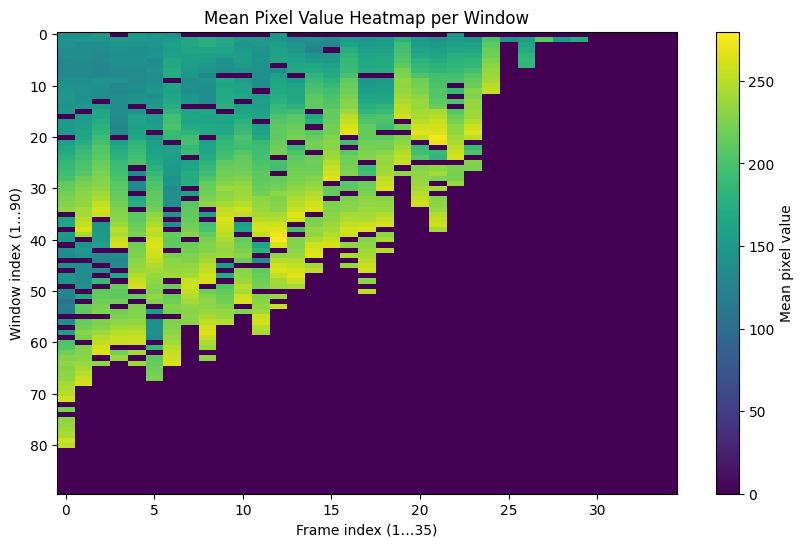

Saved trend plot to output/all_videos/KHUONG_VO_VANse000_yes_23_55_57/overall_trend.png


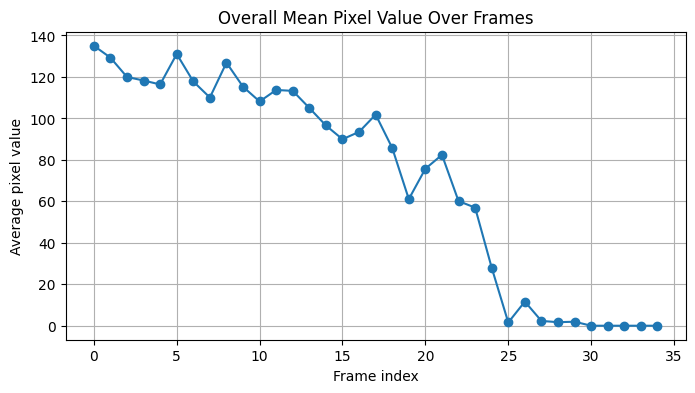

Saved selected windows plot to output/all_videos/KHUONG_VO_VANse000_yes_23_55_57/selected_windows.png


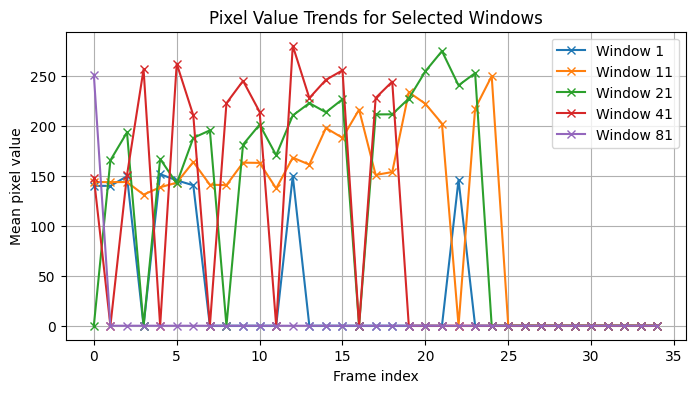

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ensure the output directory exists
OUTPUT_DIR = os.path.join("output",patient_folder)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def plot_window_heatmap(vectors, save=True, show=True):
    data = np.array(vectors)
    data[data == -1] = 0
    window_means = data.mean(axis=2)
    img = window_means.T

    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.imshow(img, aspect='auto', interpolation='nearest')
    ax.set_xlabel(f'Frame index (1…{data.shape[0]})')
    ax.set_ylabel('Window index (1…90)')
    ax.set_title('Mean Pixel Value Heatmap per Window')
    fig.colorbar(cax, label='Mean pixel value')

    if save:
        path = os.path.join(OUTPUT_DIR, "window_heatmap.png")
        fig.savefig(path, bbox_inches='tight')
        print(f"Saved heatmap to {path}")
    if show:
        plt.show()

    plt.close(fig)


def plot_overall_window_trend(vectors, save=True, show=True):
    data = np.array(vectors)
    data[data == -1] = 0
    mean_vals = data.mean(axis=(1, 2))

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(mean_vals, marker='o')
    ax.set_xlabel('Frame index')
    ax.set_ylabel('Average pixel value')
    ax.set_title('Overall Mean Pixel Value Over Frames')
    ax.grid(True)

    if save:
        path = os.path.join(OUTPUT_DIR, "overall_trend.png")
        fig.savefig(path, bbox_inches='tight')
        print(f"Saved trend plot to {path}")
    if show:
        plt.show()

    plt.close(fig)


def plot_selected_windows(vectors, window_indices=None, save=True, show=True):
    data = np.array(vectors)
    data[data == -1] = 0

    if window_indices is None:
        window_indices = list(range(5))

    fig, ax = plt.subplots(figsize=(8, 4))
    for idx in window_indices:
        vals = data[:, idx, :].mean(axis=1)
        ax.plot(vals, label=f'Window {idx + 1}', marker='x')

    ax.set_xlabel('Frame index')
    ax.set_ylabel('Mean pixel value')
    ax.set_title('Pixel Value Trends for Selected Windows')
    ax.legend()
    ax.grid(True)

    if save:
        path = os.path.join(OUTPUT_DIR, "selected_windows.png")
        fig.savefig(path, bbox_inches='tight')
        print(f"Saved selected windows plot to {path}")
    if show:
        plt.show()

    plt.close(fig)


# Example usage:
plot_window_heatmap(vectors)
plot_overall_window_trend(vectors)
plot_selected_windows(vectors, window_indices=[0, 10, 20, 40, 80])
